In [1]:
import re
import json
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import random


In [2]:
datapath = 'data/AnonyQA/'
files = ['train.json','eval.json','test.json']
topic_entity_set = set()
for file in files:
    for q in json.load(open(f'{datapath}/{file}')):
        topic_entity_set.add(q['topic_entity'])

In [43]:
kg_name = 'wyf50'
sub_map = defaultdict(list)
entity_set = set()
relation_set = set()   
for line in tqdm(set(open(f'data/kg/{kg_name}.ttl').readlines()).union(set(open('data/kg/essentail.ttl').readlines()))):
    l = line.strip().split('\t')
    s = l[0].strip()
    p = l[1].strip()
    o = l[2].strip()
    entity_set.add(s)
    entity_set.add(o)
    relation_set.add(p)
    sub_map[s].append((p, o))
    if o in topic_entity_set:
        sub_map[o].append((p+'^{-1}',s))

100%|██████████| 10616935/10616935 [01:05<00:00, 161566.75it/s]


In [44]:
print(len(entity_set))

3924536


In [4]:
test_dataset = json.load(open('data/AnonyQA/test.json'))
train_dataset = json.load(open('data/AnonyQA/train.json'))
eval_dataset = json.load(open('data/AnonyQA/eval.json'))




In [23]:
random.shuffle(test_dataset)

In [26]:
# test_dataset[0]

{'question': ' Who is named after [human_3]',
 'text': '" Lily " is a song by British rock band Queen .Lead singer [human_3] plays the piano and provides all the vocals on the track .It was originally featured on Queen \'s third album , Sheer Heart Attack , released in 1974 , and is one of the album \'s few ballads .In 1975 , " Lily " was released as the B - side of different singles in the U.K. and the United States .The U.K. single was " Now I \'m Here " , and the U.S. single was a reissue of " Keep Yourself Alive " .The lyrics refer back to a song from a previous album , " Seven Seas of Rhye " from Queen II , with the line " messenger from Seven Seas has flown , to tell the King of Rhye he \'s lost his throne . "In a 1999 interview , Brian May told the British music magazine Mojo , " [human_3] \'s stuff was so heavily cloaked , lyrically ...But you could find out , just from little insights , that a lot of his private thoughts were in there , although a lot of the more meaningful st

In [39]:
recall_rate = []
entity_range_cache = {}
entity_range_list = []
total_in = 0
total_ans = 0
for data in tqdm(test_dataset[:2000]):
    head = data['topic_entity']
    if head in entity_range_cache.keys():
        entity_range_list.append(entity_range_cache[head])
        unit_in = len(set(data['ans_ids']).intersection(entity_range_cache[head]))
        recall_rate.append(unit_in/ len(data['ans_ids']) )
        continue
    entity_range = set()
    for p, o in sub_map[head]:
        if len(entity_range) > 8e5:
            break
        # if '-1' in p and random.random() > 0.8:
        #     continue
        entity_range.add(o)
        for p2, o2 in sub_map[o]:
            if len(entity_range) > 8e5:
                break
            # if '-1' in p2 and random.random() > 0.8:
            #     continue
            entity_range.add(o2)
    entity_range_list.append(entity_range)
    entity_range_cache[head] = entity_range
    unit_in = len(set(data['ans_ids']).intersection(entity_range))
    recall_rate.append(unit_in/ len(data['ans_ids']) )
    total_in += unit_in
    total_ans += len(data['ans_ids'])
print(total_in / total_ans)
print(np.mean(recall_rate))
submap_size = np.array([len(unit) for unit in entity_range_list])
print(np.mean(submap_size))

100%|██████████| 2000/2000 [00:38<00:00, 52.13it/s] 

0.5525691699604743
0.6144842012562601
144207.0265


In [40]:

# print(submap_size)


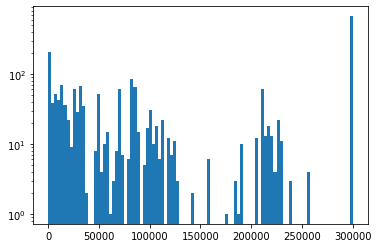

In [41]:
import matplotlib.pyplot as plt

plt.hist([len(unit) for unit in entity_range_list],bins=100)
plt.yscale('log')

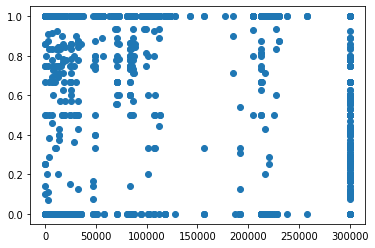

In [42]:
plt.scatter(submap_size,recall_rate)

In [55]:
8*6e4*4e5/1e9

192.0

In [59]:
5e4*3e6/1e9

150.0

: 

In [56]:
3e6

3000000.0